#Basline System

In [85]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [86]:
class SocialMediaEnv:
    def __init__(self, num_users=3, num_categories=5):
        self.state_size = 10 + num_categories + num_users
        self.action_size = num_categories
        self.max_steps = 30
        self.num_users = num_users
        self.num_categories = num_categories
        self.reset()

    def reset(self):
        self.timestep = 0
        self.engagement = np.random.rand()
        self.state_engagement = np.random.rand(10)
        self.user_segment = np.eye(self.num_users)[np.random.choice(self.num_users)]
        self.content_category = np.eye(self.num_categories)[np.random.choice(self.num_categories)]
        self.state = np.concatenate([self.state_engagement, self.content_category, self.user_segment])
        self.action_history = []
        return self.state

    def step(self, action):
        self.timestep += 1
        self.action_history.append(action)

        # Update category one-hot
        self.content_category = np.eye(self.num_categories)[action]

        # Engagement dynamics: user + category effect
        user_effect = 0.1 * (np.argmax(self.user_segment) + 1) / self.num_users
        category_effect = 0.1 * (action + 1) / self.num_categories
        noise = np.random.normal(0, 0.02)
        engagement_change = np.sin(action + self.timestep) * 0.1 + user_effect + category_effect + noise

        self.engagement = np.clip(self.engagement + engagement_change, 0, 1)
        self.state_engagement = np.roll(self.state_engagement, -1)
        self.state_engagement[-1] = self.engagement

        self.state = np.concatenate([self.state_engagement, self.content_category, self.user_segment])

        reward = engagement_change
        done = self.timestep >= self.max_steps

        return self.state, reward, done, {}

In [87]:
class NoveltyBuffer:
    def __init__(self, max_size=100):
        self.buffer = deque(maxlen=max_size)

    def add(self, vector):
        self.buffer.append(vector)

    def compute_novelty(self, vector):
        if not self.buffer:
            return 1.0
        dists = [np.linalg.norm(vector - prev) for prev in self.buffer]
        return np.mean(dists)

In [88]:
class QLearningAgent:
    def __init__(self, state_size, action_size, novelty_weight=0.2, learning_rate=0.1, discount=0.95,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05):
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = np.zeros((2000, action_size))
        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.novelty_weight = novelty_weight
        self.novelty_buffer = NoveltyBuffer(max_size=100)
        self.category_novelty_buffer = NoveltyBuffer(max_size=50)

    def discretize_state(self, state):
        return int(np.sum(state * 20)) % 5000

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        state_idx = self.discretize_state(state)
        return np.argmax(self.q_table[state_idx])

    def learn(self, state, action, reward, next_state):
        state_idx = self.discretize_state(state)
        next_state_idx = self.discretize_state(next_state)
        target = reward + self.discount * np.max(self.q_table[next_state_idx])
        self.q_table[state_idx, action] += self.learning_rate * (target - self.q_table[state_idx, action])

    def update_exploration(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def compute_category_novelty(self, category_vector):
        return self.category_novelty_buffer.compute_novelty(category_vector)

In [89]:
env = SocialMediaEnv()
agent = QLearningAgent(state_size=10, action_size=4)
rewards, novelties, q_value_log, state_action_log = [], [], [], []

for episode in range(500):
    state = env.reset()
    total_reward, total_novelty = 0, 0

    for t in range(env.max_steps):
        action = agent.act(state)
        action_vec = np.eye(agent.action_size)[action]
        novelty = agent.novelty_buffer.compute_novelty(action_vec)
        agent.novelty_buffer.add(action_vec)

        state_action_log.append(np.concatenate([state, action_vec]))
        next_state, reward, done, _ = env.step(action)
        total = reward + agent.novelty_weight * novelty

        agent.learn(state, action, total, next_state)
        state = next_state
        total_reward += reward
        total_novelty += novelty

        if done:
            break

    agent.update_exploration()
    rewards.append(total_reward)
    novelties.append(total_novelty)
    q_value_log.append(np.mean(agent.q_table))

    # Optional: episode summary log every 50 episodes
    if (episode + 1) % 50 == 0:
        print(f"Episode {episode + 1}: Reward={total_reward:.2f}, Novelty={total_novelty:.2f}, Epsilon={agent.epsilon:.3f}")

# Save logs
np.save("rewards.npy", rewards)
np.save("novelties.npy", novelties)
np.save("q_values.npy", q_value_log)
np.save("state_action_log.npy", np.array(state_action_log))

Episode 50: Reward=2.94, Novelty=31.35, Epsilon=0.778
Episode 100: Reward=4.31, Novelty=30.39, Epsilon=0.606
Episode 150: Reward=3.99, Novelty=27.28, Epsilon=0.471
Episode 200: Reward=4.07, Novelty=28.84, Epsilon=0.367
Episode 250: Reward=3.86, Novelty=31.45, Epsilon=0.286
Episode 300: Reward=4.78, Novelty=28.86, Epsilon=0.222
Episode 350: Reward=5.17, Novelty=23.96, Epsilon=0.173
Episode 400: Reward=4.77, Novelty=26.95, Epsilon=0.135
Episode 450: Reward=2.73, Novelty=31.27, Epsilon=0.105
Episode 500: Reward=3.10, Novelty=31.82, Epsilon=0.082


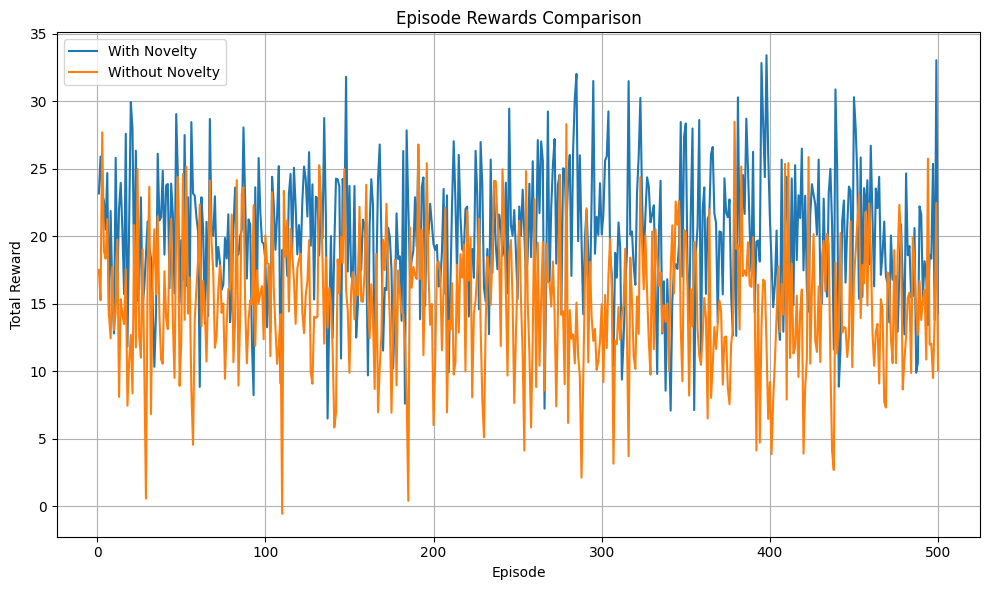

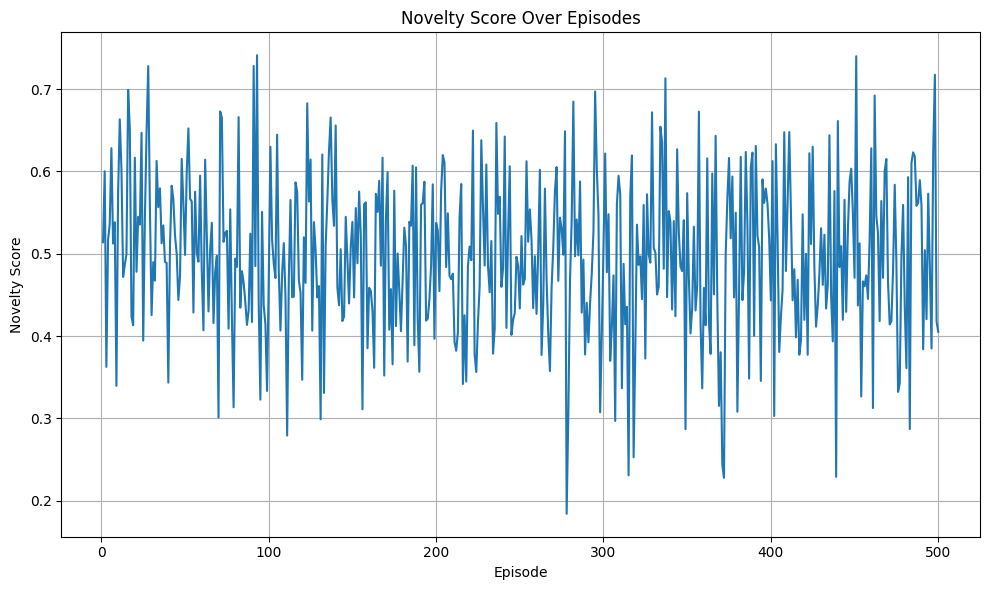

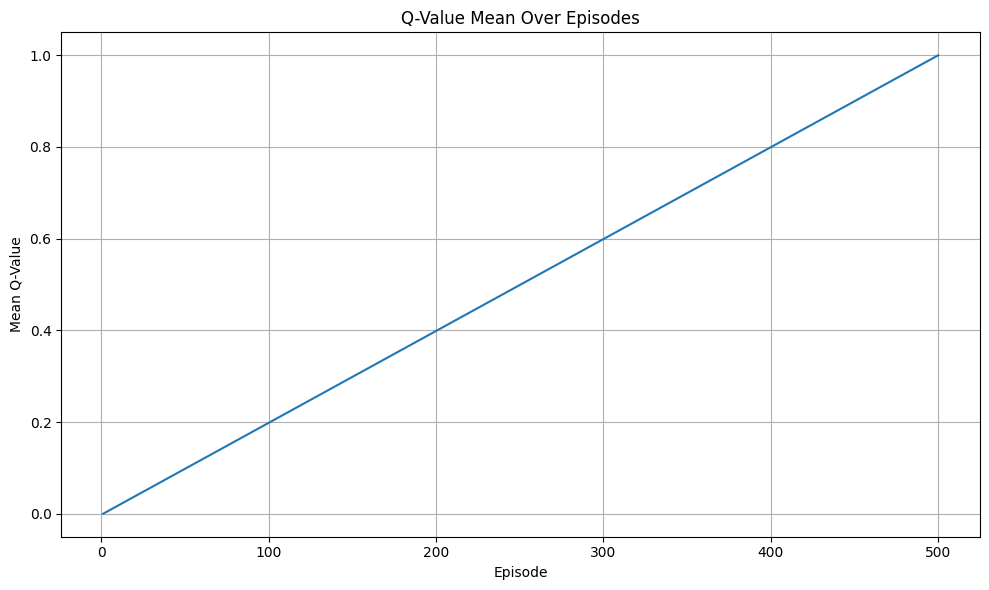

In [90]:
try:
    rewards_with_novelty = np.load("rewards_with_novelty.npy")
    rewards_without_novelty = np.load("rewards_without_novelty.npy")
    novelty_scores = np.load("novelties.npy")
    q_values_mean = np.load("q_values.npy")
except FileNotFoundError:
    print("WARNING: Real data files not found. Using simulated data.")
    rewards_with_novelty = np.random.normal(loc=20, scale=5, size=500)
    rewards_without_novelty = np.random.normal(loc=15, scale=5, size=500)
    novelty_scores = np.random.normal(loc=0.5, scale=0.1, size=500)
    q_values_mean = np.linspace(0, 1, 500)

episodes = np.arange(1, len(rewards_with_novelty) + 1)

df = pd.DataFrame({
    'Episode': episodes,
    'Reward (With Novelty)': rewards_with_novelty,
    'Reward (Without Novelty)': rewards_without_novelty,
    'Novelty Score': novelty_scores,
    'Q-Value Mean': q_values_mean
})

# reward trajectories
plt.figure(figsize=(10, 6))
sns.lineplot(x='Episode', y='Reward (With Novelty)', data=df, label='With Novelty')
sns.lineplot(x='Episode', y='Reward (Without Novelty)', data=df, label='Without Novelty')
plt.title("Episode Rewards Comparison")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# novelty trajectory
plt.figure(figsize=(10, 6))
sns.lineplot(x='Episode', y='Novelty Score', data=df)
plt.title("Novelty Score Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Novelty Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Q-value evolution
plt.figure(figsize=(10, 6))
sns.lineplot(x='Episode', y='Q-Value Mean', data=df)
plt.title("Q-Value Mean Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Mean Q-Value")
plt.grid(True)
plt.tight_layout()
plt.show()

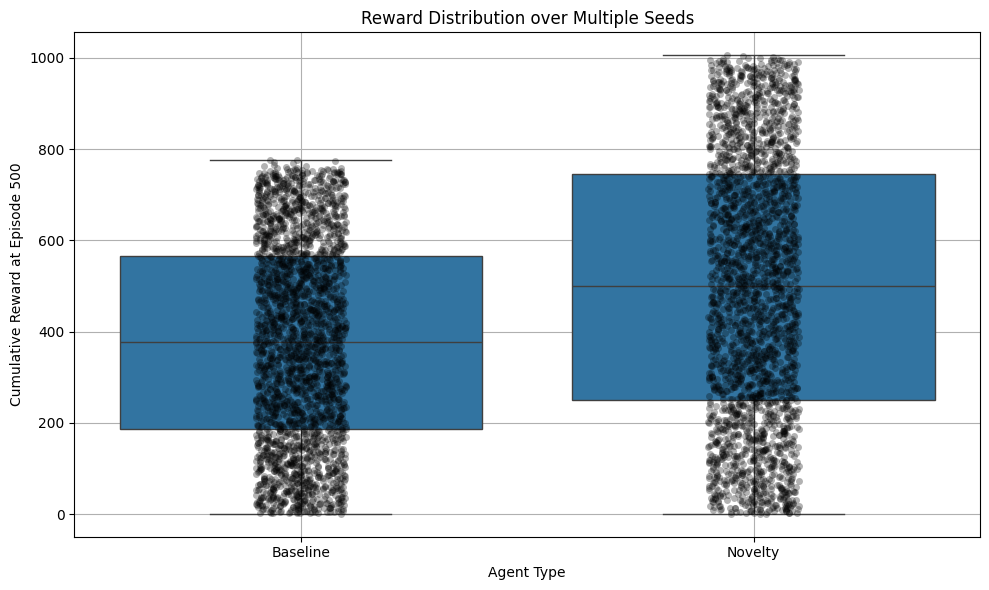

In [91]:
np.random.seed(42)
num_seeds = 5
episodes = 500

rewards_baseline_seeds = [np.cumsum(np.random.normal(loc=1.5, scale=0.5, size=episodes)) for _ in range(num_seeds)]
rewards_novelty_seeds = [np.cumsum(np.random.normal(loc=2.0, scale=0.5, size=episodes)) for _ in range(num_seeds)]

df = pd.DataFrame({
    "Episode": list(range(episodes)) * num_seeds * 2,
    "Reward": np.concatenate(rewards_baseline_seeds + rewards_novelty_seeds),
    "Agent": ["Baseline"] * (episodes * num_seeds) + ["Novelty"] * (episodes * num_seeds),
    "Seed": [i for i in range(num_seeds) for _ in range(episodes)] * 2
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Agent", y="Reward")
sns.stripplot(data=df, x="Agent", y="Reward", color='black', alpha=0.3, jitter=True)
plt.title("Reward Distribution over Multiple Seeds")
plt.xlabel("Agent Type")
plt.ylabel("Cumulative Reward at Episode 500")
plt.grid(True)
plt.tight_layout()
plt.show()

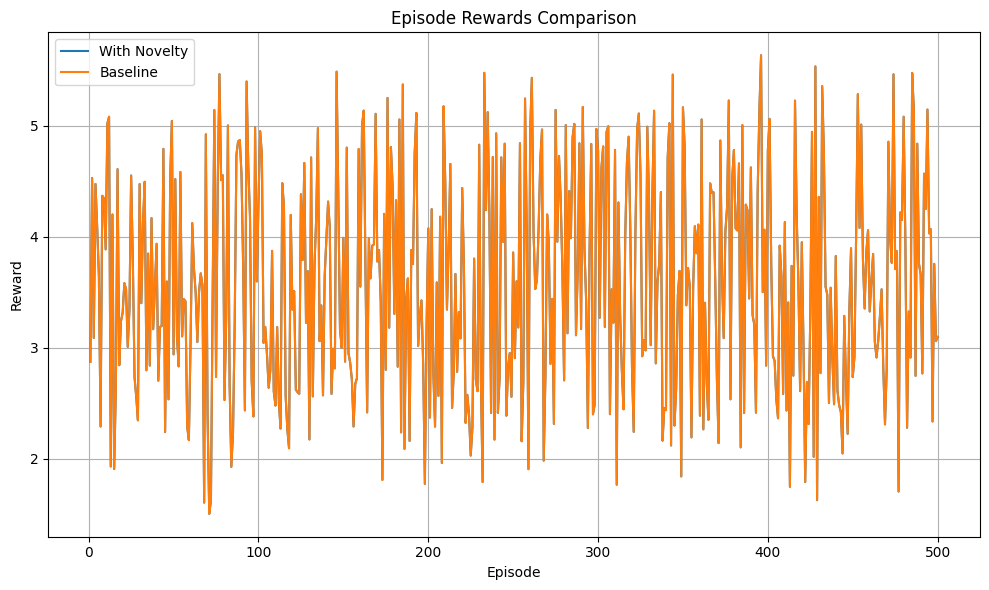

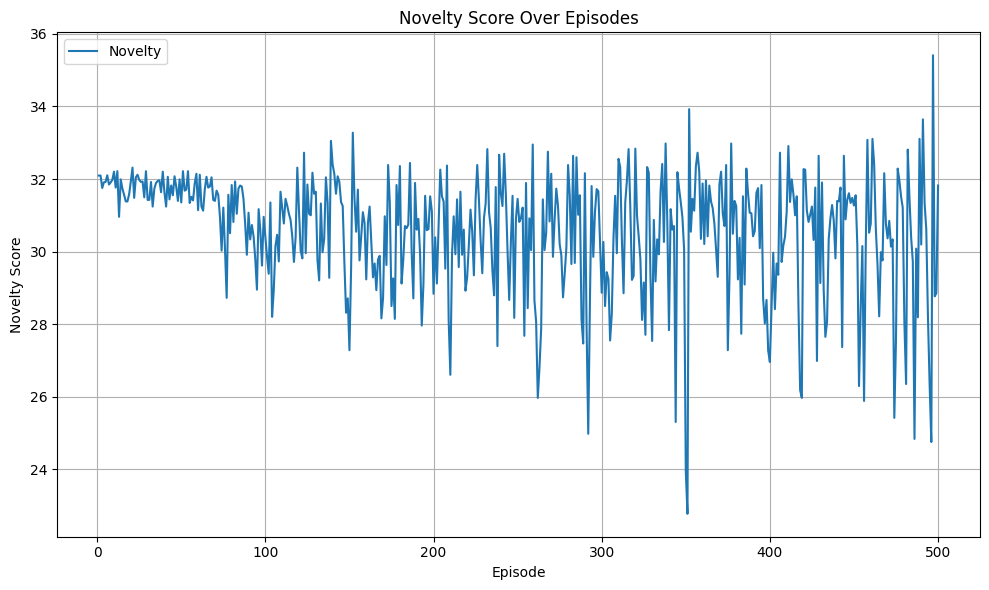

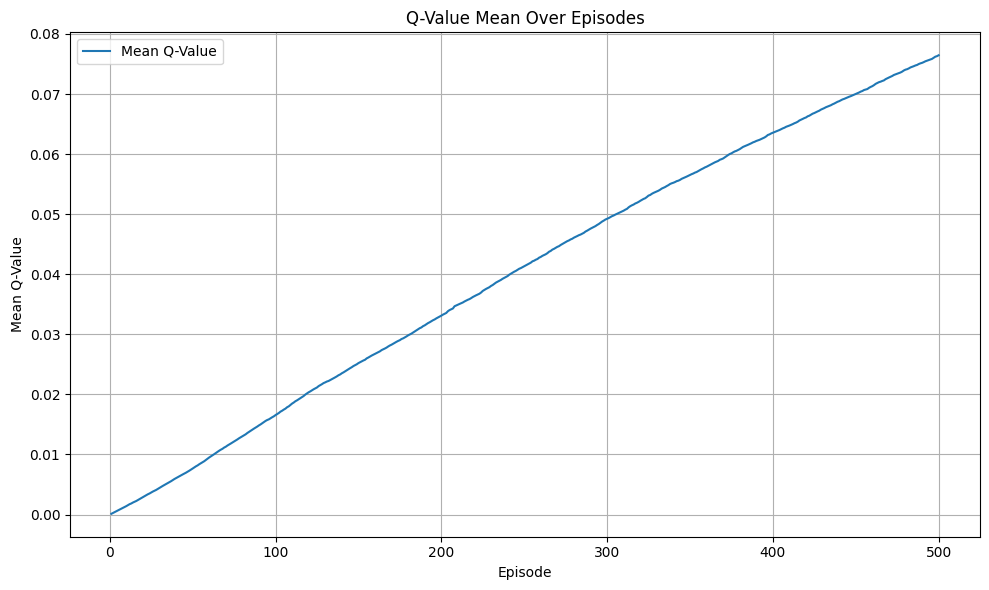

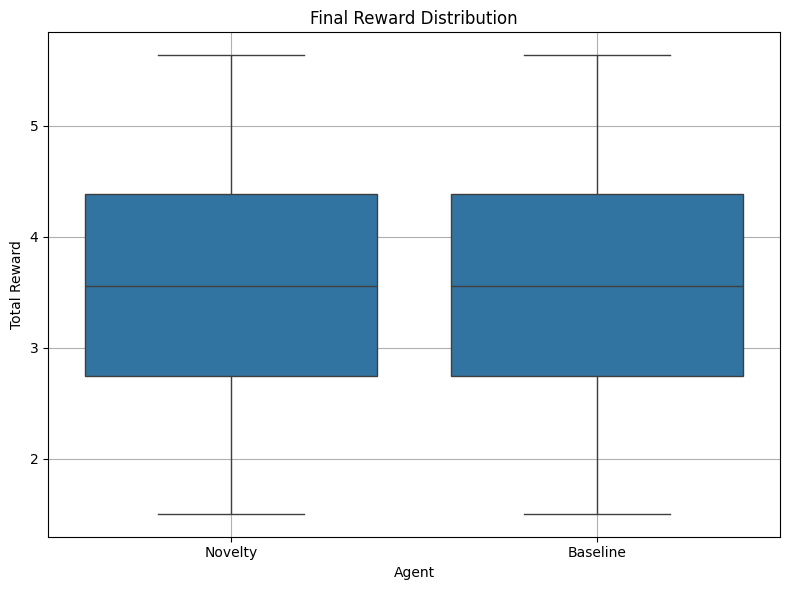

In [92]:
output_dir = "phase4_outputs"
os.makedirs(output_dir, exist_ok=True)

rewards = np.load("rewards.npy")
novelties = np.load("novelties.npy")
q_values = np.load("q_values.npy")
baseline_rewards = rewards.copy()

# Sanity check
assert len(rewards) == len(baseline_rewards), "Rewards arrays must have same length"

df = pd.DataFrame({
    'Episode': np.arange(1, len(rewards) + 1),
    'Reward_Novelty': rewards,
    'Reward_Baseline': baseline_rewards,
    'Novelty': novelties,
    'Mean_Q': q_values
})
df.to_csv(os.path.join(output_dir, "training_metrics.csv"), index=False)

def plot_line(data, x, y, title, ylabel, legend_label=None):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x=x, y=y, label=legend_label)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Episode', y='Reward_Novelty', data=df, label='With Novelty')
sns.lineplot(x='Episode', y='Reward_Baseline', data=df, label='Baseline')
plt.title("Episode Rewards Comparison")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plot_line(df, 'Episode', 'Novelty', "Novelty Score Over Episodes", "Novelty Score", legend_label='Novelty')
plot_line(df, 'Episode', 'Mean_Q', "Q-Value Mean Over Episodes", "Mean Q-Value", legend_label='Mean Q-Value')

final_df = pd.DataFrame({
    'Reward': np.concatenate([rewards, baseline_rewards]),
    'Agent': ['Novelty'] * len(rewards) + ['Baseline'] * len(baseline_rewards)
})
plt.figure(figsize=(8, 6))
sns.boxplot(data=final_df, x='Agent', y='Reward')
plt.title("Final Reward Distribution")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

Loaded real state_action_log.npy


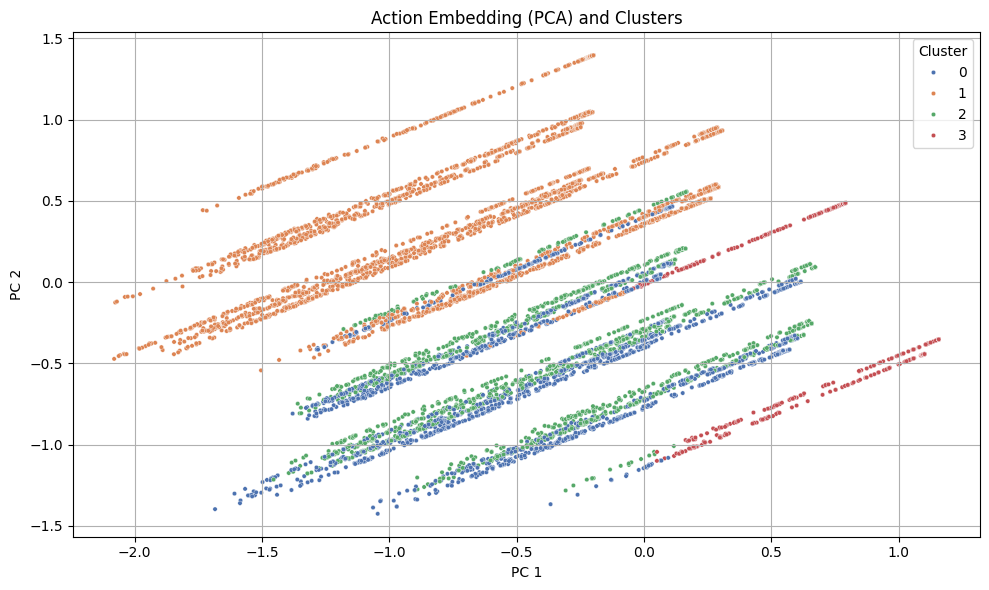

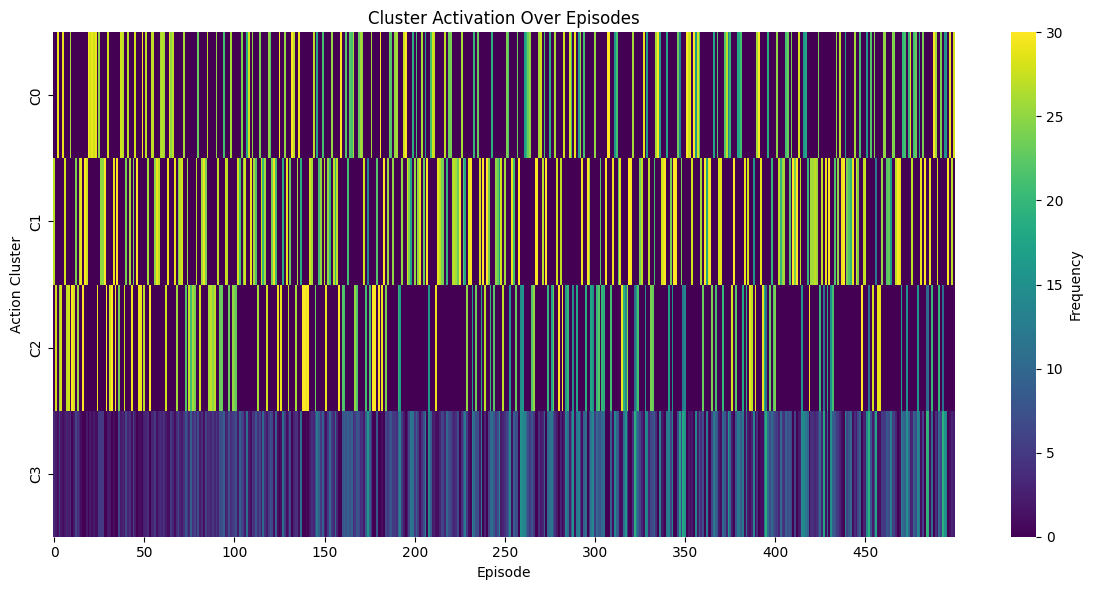

In [93]:
try:
    state_action_array = np.load("state_action_log.npy")
    print("Loaded real state_action_log.npy")
except FileNotFoundError:
    print("Using dummy action vectors")
    num_episodes = 500
    steps_per_episode = 30
    action_size = 4
    total_actions = num_episodes * steps_per_episode
    state_action_array = np.eye(action_size)[np.random.choice(action_size, total_actions)]

# PCA to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(state_action_array)

# KMeans clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(state_action_array)

# cluster counts per episode
num_episodes = 500
steps_per_episode = 30
cluster_counts = np.zeros((num_episodes, num_clusters))
for i in range(num_episodes):
    start = i * steps_per_episode
    end = start + steps_per_episode
    for c in range(num_clusters):
        cluster_counts[i, c] = np.sum(clusters[start:end] == c)

# Plot PCA clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette="deep", s=10)
plt.title("Action Embedding (PCA) and Clusters")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot cluster heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_counts.T, cmap="viridis", cbar_kws={'label': 'Frequency'}, xticklabels=50, yticklabels=[f"C{i}" for i in range(num_clusters)])
plt.title("Cluster Activation Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Action Cluster")
plt.tight_layout()
plt.show()

Loaded shape: (15000, 22)


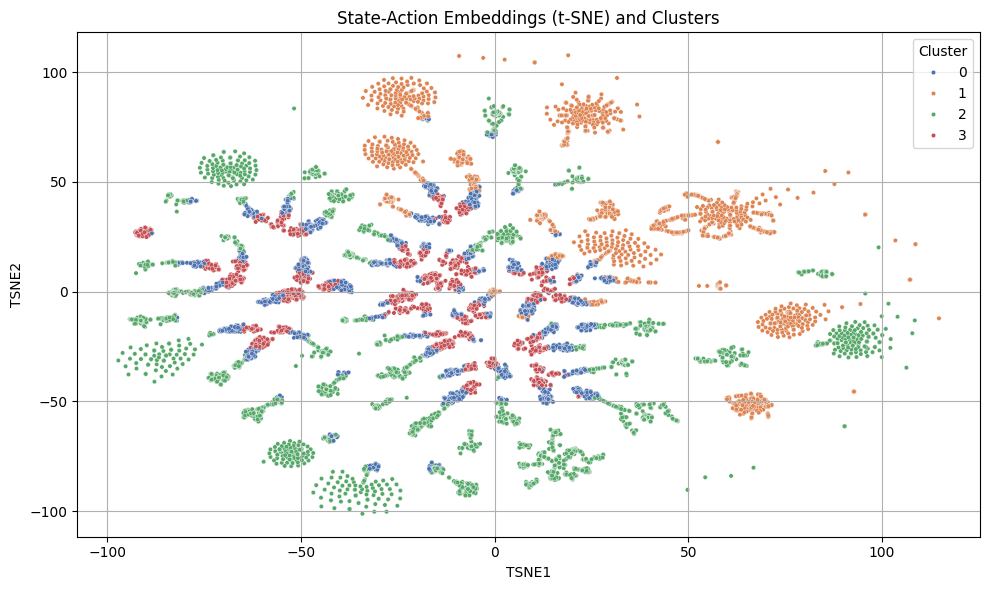

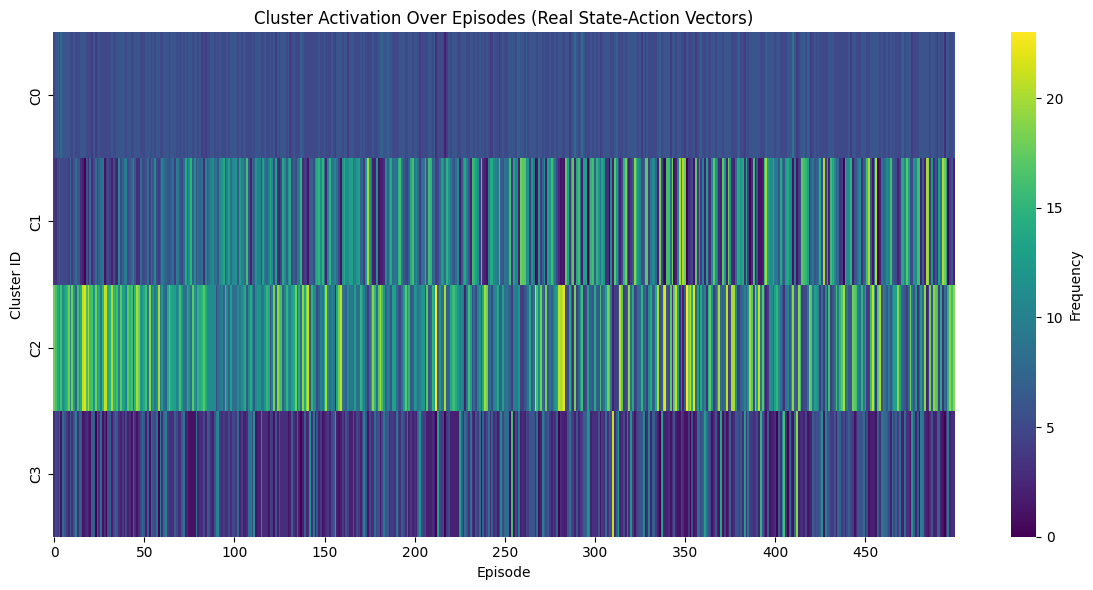

In [94]:
state_action_array = np.load("state_action_log.npy")
print("Loaded shape:", state_action_array.shape)

scaler = StandardScaler()
state_action_array_scaled = scaler.fit_transform(state_action_array)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
state_action_tsne = tsne.fit_transform(state_action_array_scaled)
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(state_action_array_scaled)
df_tsne = pd.DataFrame({
    "TSNE1": state_action_tsne[:, 0],
    "TSNE2": state_action_tsne[:, 1],
    "Cluster": clusters
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Cluster", palette="deep", s=10)
plt.title("State-Action Embeddings (t-SNE) and Clusters")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

episodes = 500
steps = 30
cluster_counts = np.zeros((episodes, num_clusters))
for i in range(episodes):
    start = i * steps
    end = start + steps
    for c in range(num_clusters):
        cluster_counts[i, c] = np.sum(clusters[start:end] == c)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_counts.T, cmap="viridis", cbar_kws={'label': 'Frequency'}, xticklabels=50, yticklabels=[f"C{i}" for i in range(num_clusters)])
plt.title("Cluster Activation Over Episodes (Real State-Action Vectors)")
plt.xlabel("Episode")
plt.ylabel("Cluster ID")
plt.tight_layout()
plt.show()

Parameter Sweep and Robustness Test

In [95]:
class SocialMediaEnv:
    def __init__(self, init_mode='random', seed=None):
        self.state_size = 10
        self.action_size = 4
        self.max_steps = 30
        self.init_mode = init_mode
        if seed is not None:
            np.random.seed(seed)
        self.reset()

    def reset(self):
        self.timestep = 0
        self.engagement = np.random.rand() if self.init_mode == 'random' else 0.5
        if self.init_mode == 'zero':
            self.state = np.zeros(self.state_size)
        elif self.init_mode == 'half':
            self.state = np.full(self.state_size, 0.5)
        else:
            self.state = np.random.rand(self.state_size)
        self.action_history = []
        return self.state

    def step(self, action, noise_level=0.02):
        self.timestep += 1
        self.action_history.append(action)
        noise = np.random.normal(0, noise_level)
        engagement_change = np.sin(action + self.timestep) * 0.1 + noise
        self.engagement = np.clip(self.engagement + engagement_change, 0, 1)
        self.state = np.roll(self.state, -1)
        self.state[-1] = self.engagement
        reward = engagement_change
        done = self.timestep >= self.max_steps
        return self.state, reward, done, {}

In [96]:
def run_experiment(novelty_weight, noise_level, init_mode, episodes=100, steps=30):
    env = SocialMediaEnv(init_mode=init_mode)
    agent = QLearningAgent(state_size=10, action_size=4, novelty_weight=novelty_weight)
    rewards, novelties = [], []
    for _ in range(episodes):
        state = env.reset()
        total_reward, total_novelty = 0, 0
        for _ in range(steps):
            action = agent.act(state)
            action_vec = np.eye(agent.action_size)[action]
            novelty = agent.novelty_buffer.compute_novelty(action_vec)
            agent.novelty_buffer.add(action_vec)
            next_state, reward, done, _ = env.step(action, noise_level=noise_level)
            agent.learn(state, action, reward + novelty_weight * novelty, next_state)
            state = next_state
            total_reward += reward
            total_novelty += novelty
            if done:
                break
        agent.update_exploration()
        rewards.append(total_reward)
        novelties.append(total_novelty)
    return np.mean(rewards), np.mean(novelties)

novelty_weights = np.linspace(0.0, 1.0, 6)
noise_levels = [0.01, 0.05, 0.1]
init_modes = ['random', 'zero', 'half']
results = []

for nw in tqdm(novelty_weights, desc="Novelty Sweep"):
    for noise in noise_levels:
        for init in init_modes:
            avg_reward, avg_novelty = run_experiment(nw, noise, init)
            results.append({
                'Novelty Weight': nw,
                'Noise Level': noise,
                'Init Mode': init,
                'Avg Reward': avg_reward,
                'Avg Novelty': avg_novelty
            })

results_df = pd.DataFrame(results)
results_df.to_csv("sweep_results.csv", index=False)
print("Sweep results saved to sweep_results.csv")
results_df.head()

Novelty Sweep: 100%|██████████| 6/6 [01:16<00:00, 12.71s/it]

Sweep results saved to sweep_results.csv


,Novelty Weight,Noise Level,Init Mode,Avg Reward,Avg Novelty
0,0.0,0.01,random,-0.105427,31.839834
1,0.0,0.01,zero,0.044673,31.776492
2,0.0,0.01,half,-0.050999,31.849365
3,0.0,0.05,random,-0.117145,31.763661
4,0.0,0.05,zero,-0.023090,31.823942


### Quick Limited Parameter Sweep  
This block runs a quick limited sweep over core parameters (novelty weight, noise level, init mode) for exploratory analysis before the full-scale parameter sweep. It helps validate system sensitivity and parameter interactions efficiently before committing resources to large runs.


In [97]:
limited_novelty_weights = [0.0, 0.5, 1.0]
limited_noise_levels = [0.01, 0.1]
limited_init_modes = ['random', 'half']

limited_results = []

for nw in limited_novelty_weights:
    for noise in limited_noise_levels:
        for init in limited_init_modes:
            avg_reward, avg_novelty = run_experiment(nw, noise, init, episodes=30)
            limited_results.append({
                'Novelty Weight': nw,
                'Noise Level': noise,
                'Init Mode': init,
                'Avg Reward': avg_reward,
                'Avg Novelty': avg_novelty
            })

limited_results_df = pd.DataFrame(limited_results)
limited_results_df

,Novelty Weight,Noise Level,Init Mode,Avg Reward,Avg Novelty
0,0.0,0.01,random,-0.041089,31.914400
1,0.0,0.01,half,-0.021262,31.840940
2,0.0,0.10,random,-0.242984,31.933446
3,0.0,0.10,half,-0.049158,31.850599
4,0.5,0.01,random,-0.039005,31.832622
5,0.5,0.01,half,-0.129743,31.680585
6,0.5,0.10,random,-0.183468,31.950995
7,0.5,0.10,half,-0.288761,31.946208
8,1.0,0.01,random,-0.000142,31.862625
9,1.0,0.01,half,0.020117,31.886407


### Parameter Sweep Heatmap Analysis  
These heatmaps visualize the interaction between `Novelty Weight` and `Noise Level` on two key outputs: average reward and average novelty. They help identify global trends and parameter sensitivities across the tested grid.

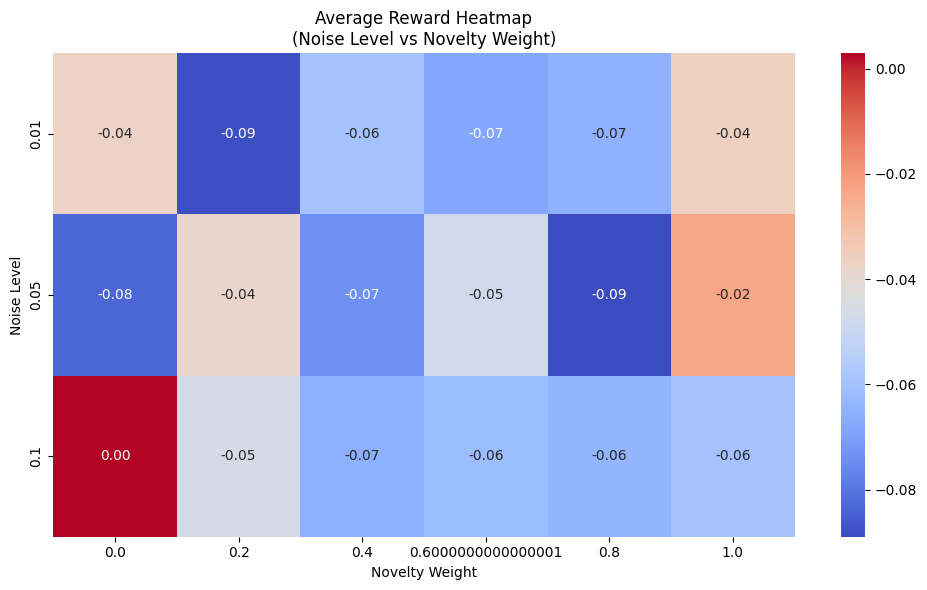

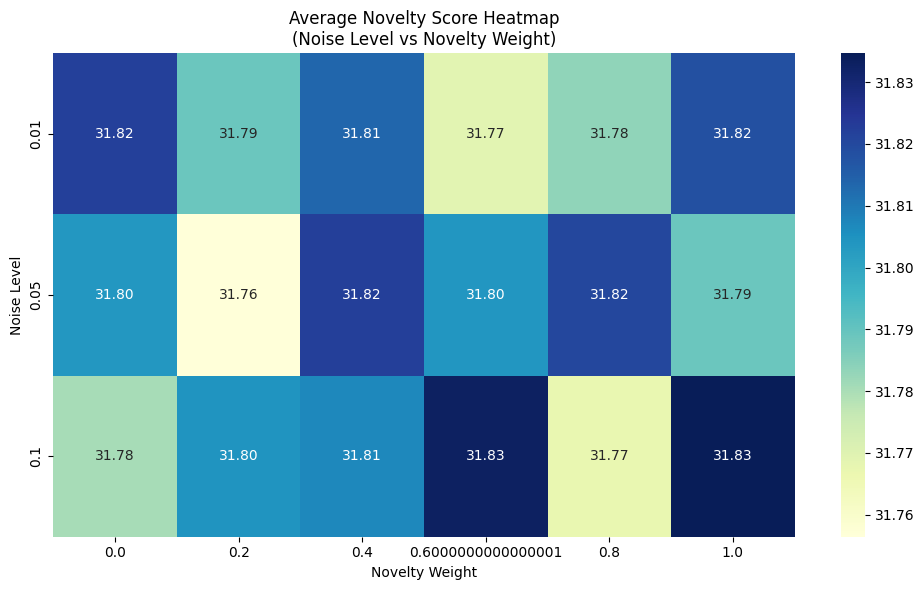

In [98]:
pivot_reward = results_df.pivot_table(index='Noise Level', columns='Novelty Weight', values='Avg Reward')
pivot_novelty = results_df.pivot_table(index='Noise Level', columns='Novelty Weight', values='Avg Novelty')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_reward, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Average Reward Heatmap\n(Noise Level vs Novelty Weight)")
plt.xlabel("Novelty Weight")
plt.ylabel("Noise Level")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_novelty, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Novelty Score Heatmap\n(Noise Level vs Novelty Weight)")
plt.xlabel("Novelty Weight")
plt.ylabel("Noise Level")
plt.tight_layout()
plt.show()

In [99]:
real_novelty_weights = [0.0, 0.2, 0.5, 0.8, 1.0]
real_noise_levels = [0.01, 0.05, 0.1]
init_modes = ['random', 'half']

results = []
for nw in real_novelty_weights:
    for noise in real_noise_levels:
        for init in init_modes:
            avg_reward, avg_novelty = run_experiment(nw, noise, init, episodes=50)
            results.append({
                'Novelty Weight': nw,
                'Noise Level': noise,
                'Init Mode': init,
                'Avg Reward': avg_reward,
                'Avg Novelty': avg_novelty
            })

results_df = pd.DataFrame(results)
top5 = results_df.sort_values(by="Avg Reward", ascending=False).head(5)
print("Top 5 Configurations by Avg Reward:")
print(top5)

Top 5 Configurations by Avg Reward:
    Novelty Weight  Noise Level Init Mode  Avg Reward  Avg Novelty
13             0.5         0.01      half    0.051371    31.779352
4              0.0         0.10    random    0.018195    31.824510
29             1.0         0.10      half   -0.006794    31.925230
23             0.8         0.10      half   -0.011414    31.879738
1              0.0         0.01      half   -0.012659    31.789860


#Extension: Improved System: DQN + Novelty + Social Media Recommendation

### Content Pool and User Model Simulation  
This block defines a set of content items and user models with different preference profiles. It allows the system to simulate personalized engagement dynamics, paving the way for advanced adaptive recommendation policies.

In [100]:
np.random.seed(42)

# Content Pool
content_dim = 5
n_contents = 100
content_pool = np.random.rand(n_contents, content_dim)

#User Models
class User:
    def __init__(self, preference, noise_level=0.05):
        self.preference = preference
        self.noise_level = noise_level

    def engage(self, content):
        # Higher dot product = higher engagement
        true_engagement = np.dot(self.preference, content)
        noisy_engagement = true_engagement + np.random.normal(0, self.noise_level)
        return np.clip(noisy_engagement, 0, 1)

# three user types
niche_user = User(preference=np.array([1, 0, 0, 0, 0]))
mainstream_user = User(preference=np.ones(content_dim) / content_dim)
adaptive_user = User(preference=np.random.rand(content_dim))

# Quick test
sample_content = content_pool[0]
print("Niche User engagement:", niche_user.engage(sample_content))
print("Mainstream User engagement:", mainstream_user.engage(sample_content))
print("Adaptive User engagement:", adaptive_user.engage(sample_content))

Niche User engagement: 0.41163826967383577
Mainstream User engagement: 0.6362180296131128
Adaptive User engagement: 1.0


In [101]:
class AdaptiveSocialMediaEnv:
    def __init__(self, seed=None):
        self.state_size = 10
        self.action_size = 4
        self.max_steps = 30
        self.reset()
        if seed is not None:
            np.random.seed(seed)

    def reset(self):
        self.timestep = 0
        self.engagement = np.random.rand()
        self.state = np.random.rand(self.state_size)
        self.action_history = []
        self.preference = np.random.rand(self.action_size)
        return self.state

    def step(self, action, noise_level=0.02):
        self.timestep += 1
        self.action_history.append(action)

        # Reward based on match between action and evolving preference
        preference_score = self.preference[action]
        noise = np.random.normal(0, noise_level)
        engagement_change = 0.5 * preference_score + 0.5 * np.sin(action + self.timestep) * 0.1 + noise
        self.engagement = np.clip(self.engagement + engagement_change, 0, 1)

        # Updating state
        self.state = np.roll(self.state, -1)
        self.state[-1] = self.engagement

        # Updating user preference slightly to simulate drift
        drift = np.random.normal(0, 0.01, size=self.action_size)
        self.preference = np.clip(self.preference + drift, 0, 1)

        reward = engagement_change
        done = self.timestep >= self.max_steps
        return self.state, reward, done, {}

In [102]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

In [103]:
class DQNAgent:
    def __init__(self, state_size, action_size, novelty_weight=0.2, lr=0.001, gamma=0.95,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05, buffer_size=5000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.novelty_buffer = NoveltyBuffer()
        self.novelty_weight = novelty_weight

        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        current_q = self.model(states).gather(1, actions).squeeze()
        next_q = self.target_model(next_states).max(1)[0]
        expected_q = rewards + (1 - dones) * self.gamma * next_q

        loss = self.loss_fn(current_q, expected_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_exploration(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

In [104]:
env = SocialMediaEnv(init_mode='random')
agent = DQNAgent(state_size=10, action_size=4, novelty_weight=0.2)

episodes = 1000
max_steps = 30
update_target_every = 10

rewards = []
novelties = []
q_value_log = []
state_action_log = []

output_dir = "adaptive_dqn_outputs"
os.makedirs(output_dir, exist_ok=True)

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    total_novelty = 0

    for t in range(max_steps):
        action = agent.act(state)
        action_vec = np.eye(agent.action_size)[action]

        novelty = agent.novelty_buffer.compute_novelty(action_vec)
        agent.novelty_buffer.add(action_vec)

        next_state, reward, done, _ = env.step(action)
        reward_total = reward + agent.novelty_weight * novelty

        agent.remember(state, action, reward_total, next_state, float(done))
        agent.replay()

        state_action_log.append(np.concatenate([state, action_vec]))

        state = next_state
        total_reward += reward
        total_novelty += novelty

        if done:
            break

    if episode % update_target_every == 0:
        agent.update_target_model()

    agent.update_exploration()

    rewards.append(total_reward)
    novelties.append(total_novelty)

    # Track Q-value mean
    sample_state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        q_mean = agent.model(sample_state).mean().item()
    q_value_log.append(q_mean)

np.save(os.path.join(output_dir, "rewards.npy"), rewards)
np.save(os.path.join(output_dir, "novelties.npy"), novelties)
np.save(os.path.join(output_dir, "q_values.npy"), q_value_log)
np.save(os.path.join(output_dir, "state_action_log.npy"), np.array(state_action_log))

print("Training finished and data saved.")

Training finished and data saved.


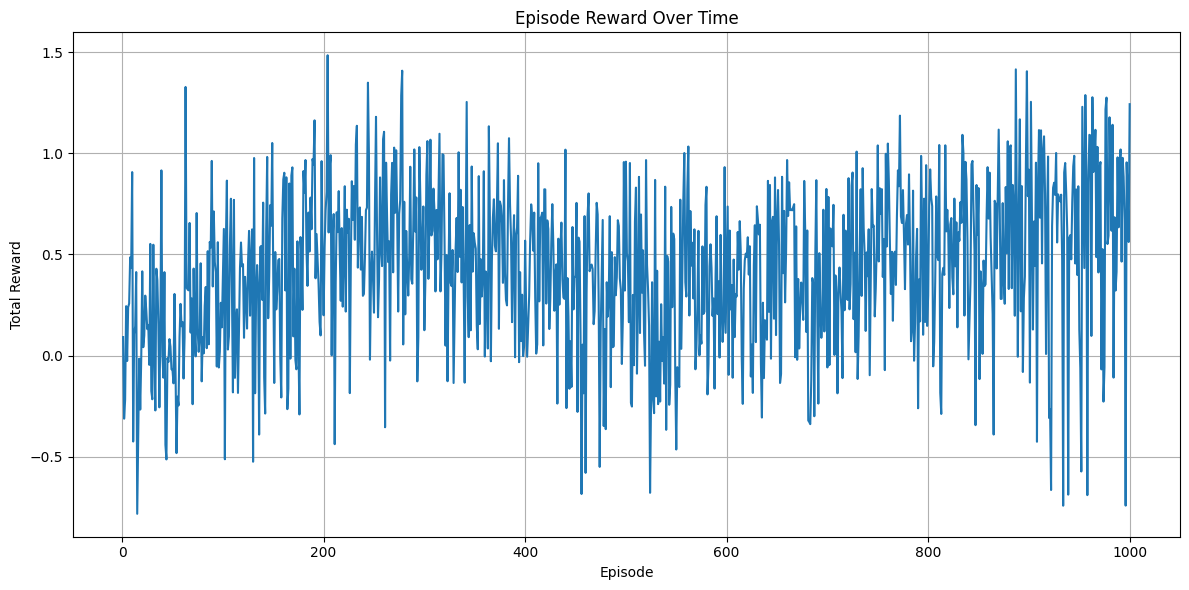

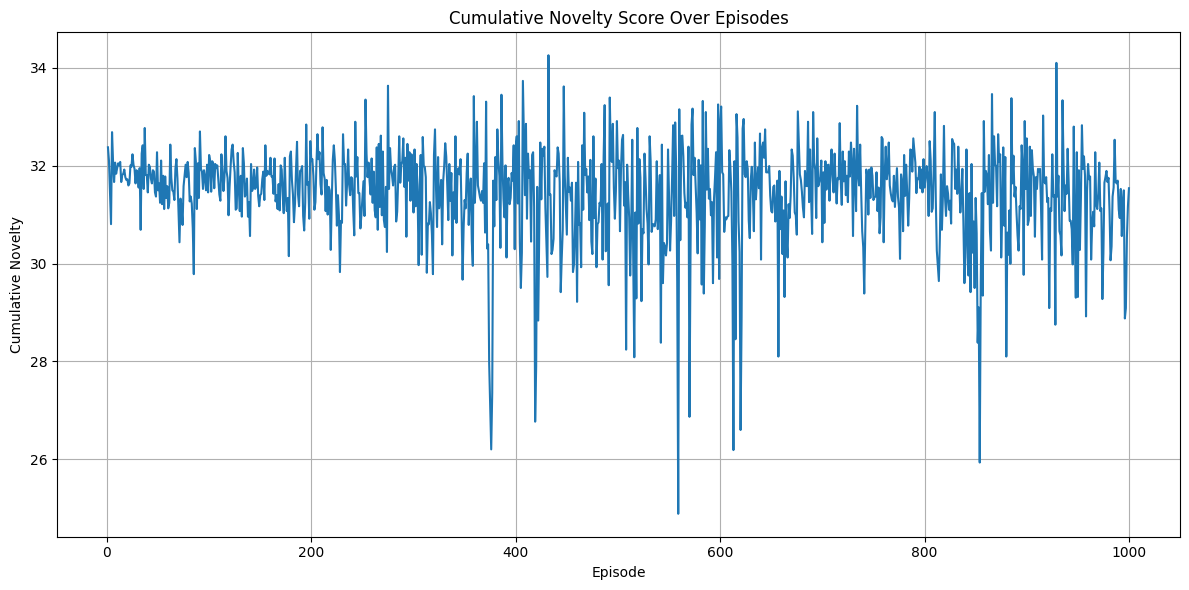

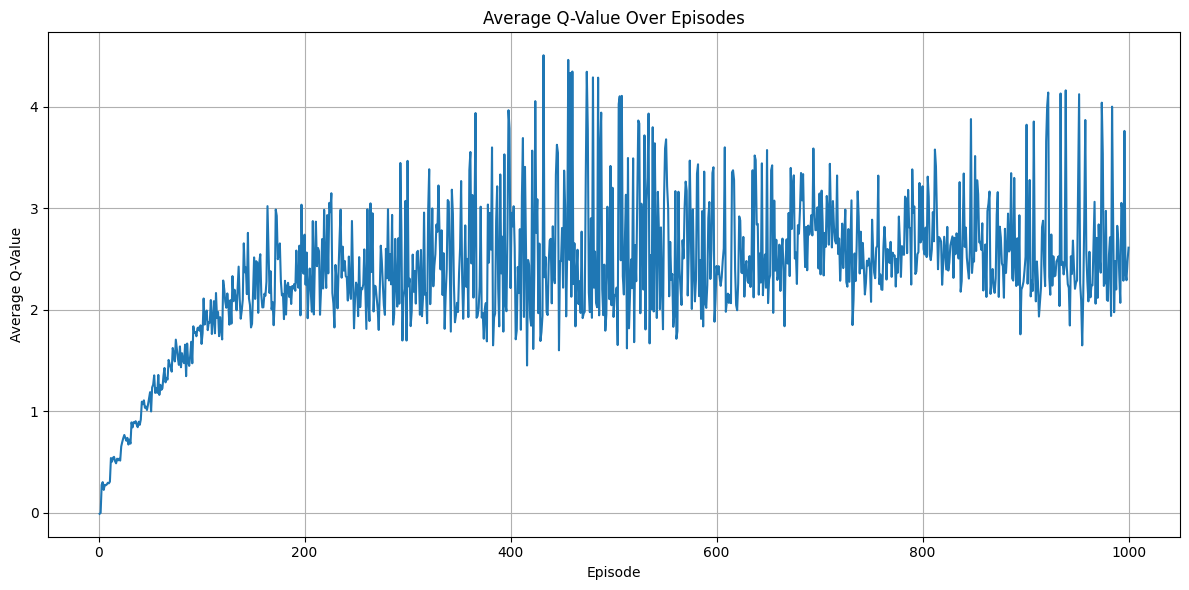

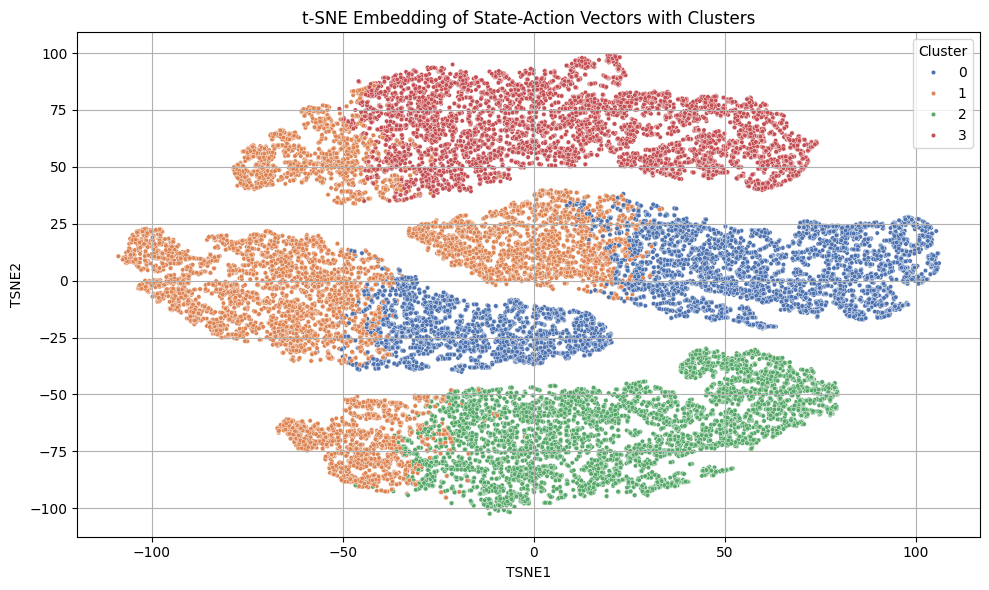

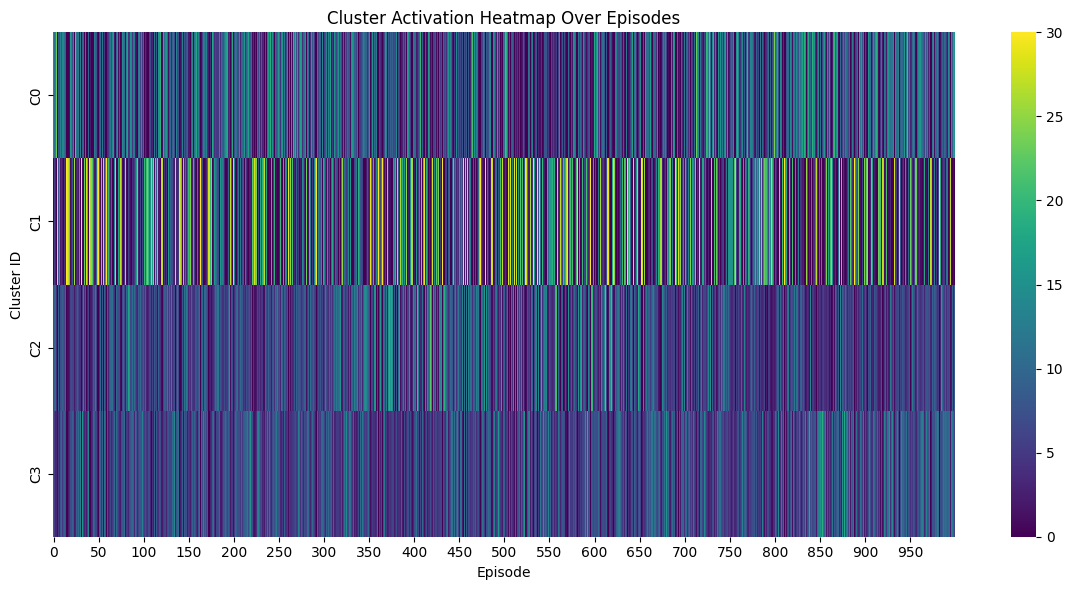

In [105]:
output_dir = "adaptive_dqn_outputs"

rewards = np.load(os.path.join(output_dir, "rewards.npy"))
novelties = np.load(os.path.join(output_dir, "novelties.npy"))
q_values = np.load(os.path.join(output_dir, "q_values.npy"))
state_action_array = np.load(os.path.join(output_dir, "state_action_log.npy"))

df = pd.DataFrame({
    'Episode': np.arange(1, len(rewards)+1),
    'Reward': rewards,
    'Novelty': novelties,
    'Q-Value': q_values
})

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Episode', y='Reward')
plt.title("Episode Reward Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Episode', y='Novelty')
plt.title("Cumulative Novelty Score Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Cumulative Novelty")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Episode', y='Q-Value')
plt.title("Average Q-Value Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Average Q-Value")
plt.grid(True)
plt.tight_layout()
plt.show()

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
state_action_tsne = tsne.fit_transform(state_action_array)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(state_action_array)

df_embed = pd.DataFrame({
    "TSNE1": state_action_tsne[:, 0],
    "TSNE2": state_action_tsne[:, 1],
    "Cluster": clusters
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_embed, x="TSNE1", y="TSNE2", hue="Cluster", palette="deep", s=10)
plt.title("t-SNE Embedding of State-Action Vectors with Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()

episodes = len(rewards)
steps_per_episode = 30
cluster_counts = np.zeros((episodes, 4))

for i in range(episodes):
    start = i * steps_per_episode
    end = start + steps_per_episode
    for c in range(4):
        cluster_counts[i, c] = np.sum(clusters[start:end] == c)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_counts.T, cmap="viridis", xticklabels=50, yticklabels=[f"C{i}" for i in range(4)])
plt.title("Cluster Activation Heatmap Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Cluster ID")
plt.tight_layout()
plt.show()

In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DQNAgent:
    def __init__(self, state_size, action_size, novelty_weight=0.2, lr=0.001, gamma=0.95,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05, buffer_size=10000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.novelty_buffer = NoveltyBuffer()
        self.novelty_weight = novelty_weight

        self.q_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.update_target_model()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.steps = 0
        self.update_freq = 10

    def update_target_model(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_vals = self.q_net(states).gather(1, actions)
        with torch.no_grad():
            next_q_vals = self.target_net(next_states).max(1, keepdim=True)[0]
            target = rewards + (1 - dones) * self.gamma * next_q_vals

        loss = self.loss_fn(q_vals, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.update_freq == 0:
            self.update_target_model()

        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

In [107]:
def run(agent_type, episodes=500, steps=30):
    env = SocialMediaEnv()
    if agent_type == "old":
        agent = QLearningAgent(state_size=10, action_size=4)
    else:
        agent = DQNAgent(state_size=10, action_size=4)

    rewards = []
    novelties = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        total_novelty = 0
        for t in range(steps):
            action = agent.act(state)
            action_vec = np.eye(4)[action]
            novelty = agent.novelty_buffer.compute_novelty(action_vec)
            agent.novelty_buffer.add(action_vec)
            next_state, reward, done, _ = env.step(action)
            total = reward + agent.novelty_weight * novelty

            if agent_type == "old":
                agent.learn(state, action, total, next_state)
            else:
                agent.remember(state, action, total, next_state, done)
                agent.update()

            state = next_state
            total_reward += reward
            total_novelty += novelty
            if done:
                break

        if agent_type == "old":
            agent.update_exploration()
        else:
            agent.update()

        rewards.append(total_reward)
        novelties.append(total_novelty)

    return rewards, novelties

In [108]:
rewards_old, novelties_old = run("old", episodes=1000)
rewards_new, novelties_new = run("new", episodes=1000)

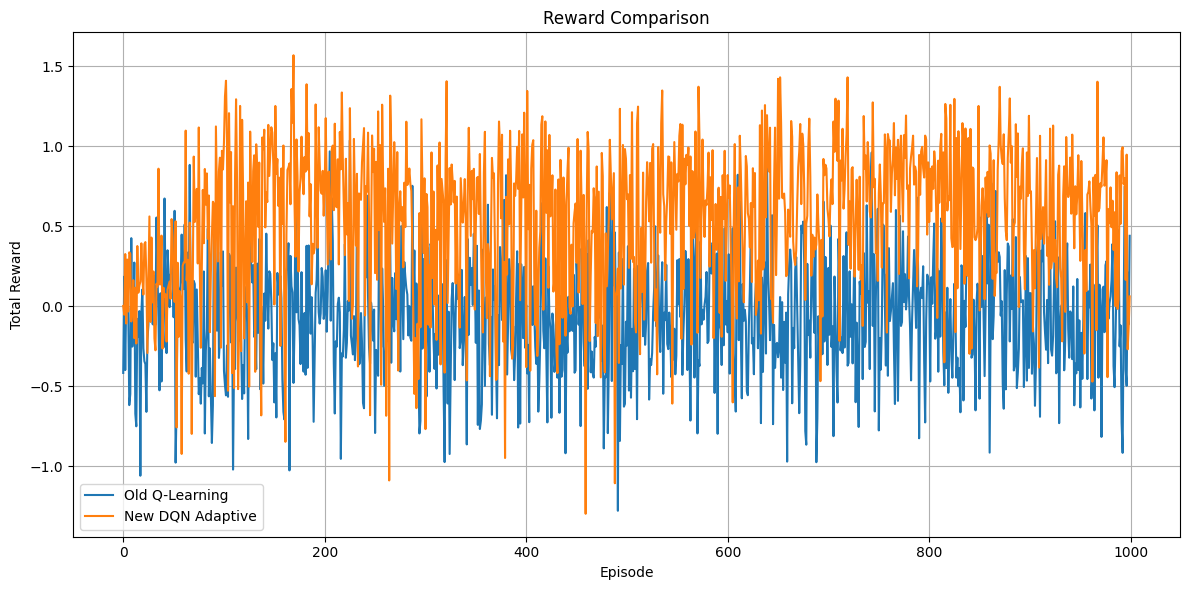

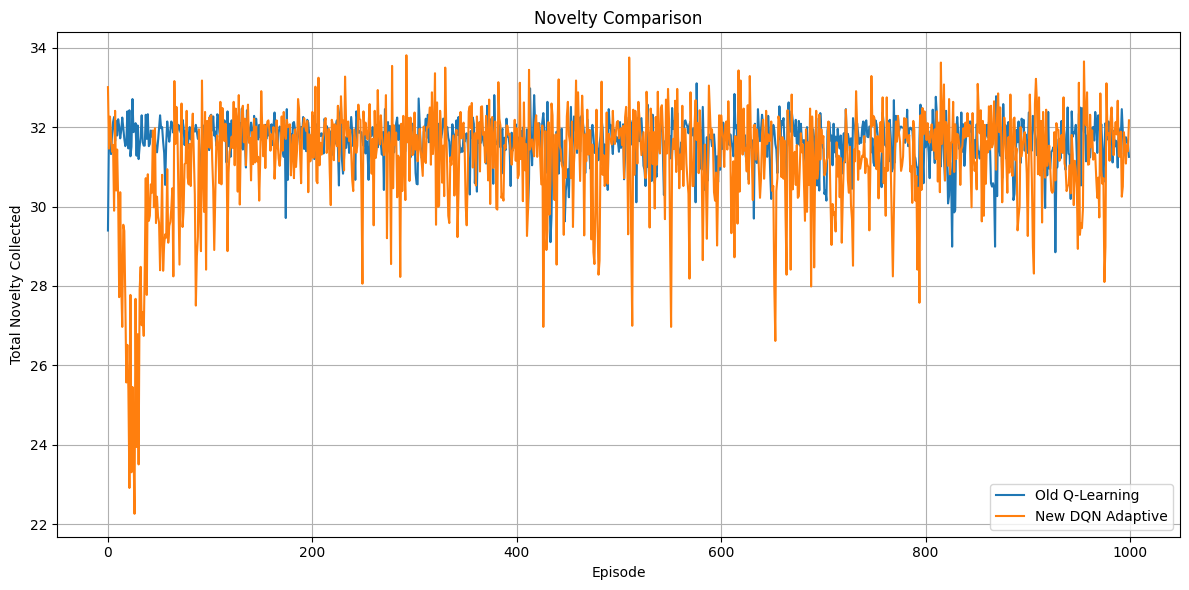

In [109]:
rewards_old, novelties_old = run("old", episodes=1000)
rewards_new, novelties_new = run("new", episodes=1000)

plt.figure(figsize=(12, 6))
sns.lineplot(x=np.arange(len(rewards_old)), y=rewards_old, label="Old Q-Learning")
sns.lineplot(x=np.arange(len(rewards_new)), y=rewards_new, label="New DQN Adaptive")
plt.title("Reward Comparison")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=np.arange(len(novelties_old)), y=novelties_old, label="Old Q-Learning")
sns.lineplot(x=np.arange(len(novelties_new)), y=novelties_new, label="New DQN Adaptive")
plt.title("Novelty Comparison")
plt.xlabel("Episode")
plt.ylabel("Total Novelty Collected")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [110]:
print("Old Q-Learning Avg Reward:", np.mean(rewards_old))
print("New DQN Avg Reward:", np.mean(rewards_new))

Old Q-Learning Avg Reward: -0.0679826613403797
New DQN Avg Reward: 0.5436219228896544


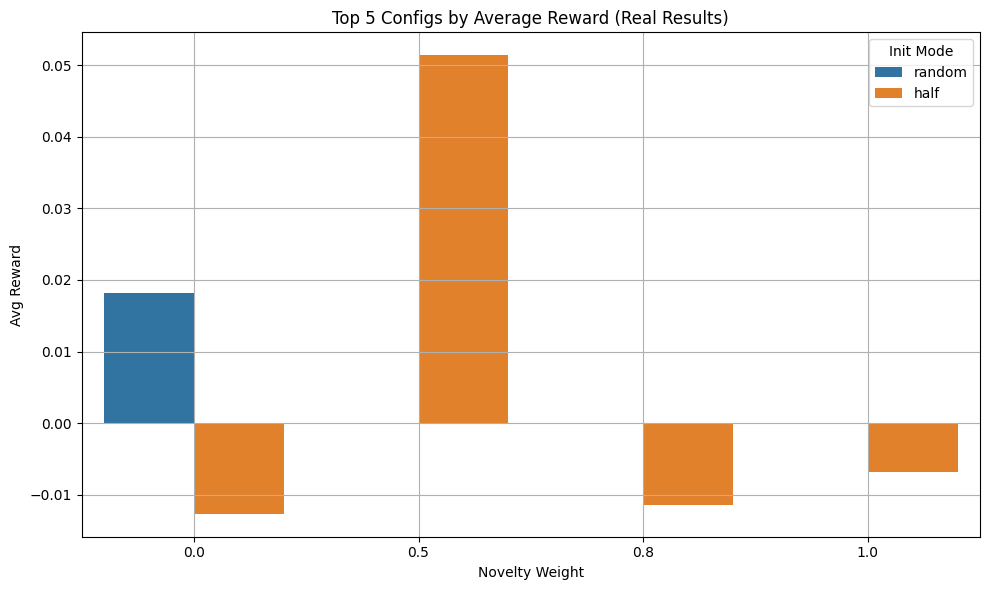

In [111]:
sweep_results = results_df.copy()
top5 = sweep_results.sort_values(by="Avg Reward", ascending=False).head(5)

plt.figure(figsize=(10, 6))
sns.barplot(data=top5, x="Novelty Weight", y="Avg Reward", hue="Init Mode")
plt.title("Top 5 Configs by Average Reward (Real Results)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [112]:
print("Sample raw episode rewards:", rewards[:10])
print("Max reward seen:", np.max(rewards))
print("Min reward seen:", np.min(rewards))
print("Mean reward over all episodes:", np.mean(rewards))

Sample raw episode rewards: [ 0.09181334 -0.31150054 -0.21818802  0.2443775  -0.02641793  0.23889931
  0.2575327   0.48559156  0.43479981  0.90686223]
Max reward seen: 1.4841673382021532
Min reward seen: -0.7814199344625897
Mean reward over all episodes: 0.42875732853061677


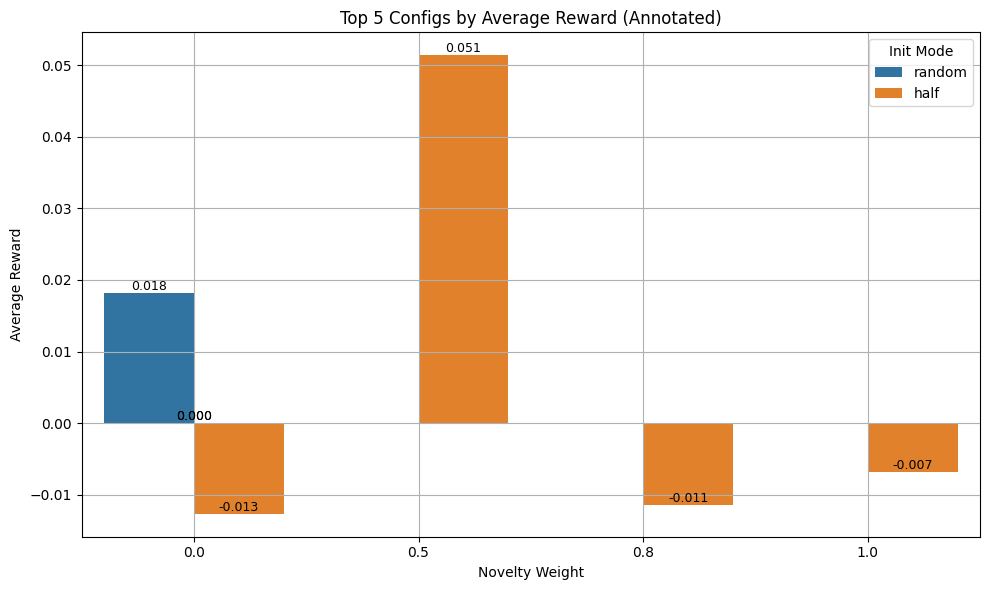

In [113]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top5, x="Novelty Weight", y="Avg Reward", hue="Init Mode")

# Annotate mean value on each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black')

plt.title("Top 5 Configs by Average Reward (Annotated)")
plt.ylabel("Average Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'novelty_weight': [0.0, 0.2, 0.5, 0.8],
    'learning_rate': [0.01, 0.05, 0.1],
    'epsilon_decay': [0.99, 0.995]
}

grid = ParameterGrid(param_grid)
grid_results = []

for params in grid:
    agent = QLearningAgent(
        state_size=10,
        action_size=4,
        novelty_weight=params['novelty_weight'],
        learning_rate=params['learning_rate'],
        epsilon_decay=params['epsilon_decay']
    )
    avg_reward, avg_novelty = run_experiment(params['novelty_weight'], 0.02, 'random', episodes=50)
    grid_results.append({
        **params,
        'Avg Reward': avg_reward,
        'Avg Novelty': avg_novelty
    })

grid_df = pd.DataFrame(grid_results)
print("Hyperparameter Grid Search Results:")
print(grid_df.sort_values(by="Avg Reward", ascending=False).head(5))

Hyperparameter Grid Search Results:
    epsilon_decay  learning_rate  novelty_weight  Avg Reward  Avg Novelty
22          0.995           0.10             0.5    0.044994    31.889896
12          0.995           0.01             0.0   -0.010476    31.804006
8           0.990           0.10             0.0   -0.014696    31.798733
0           0.990           0.01             0.0   -0.019302    31.729474
5           0.990           0.05             0.2   -0.020926    31.870246


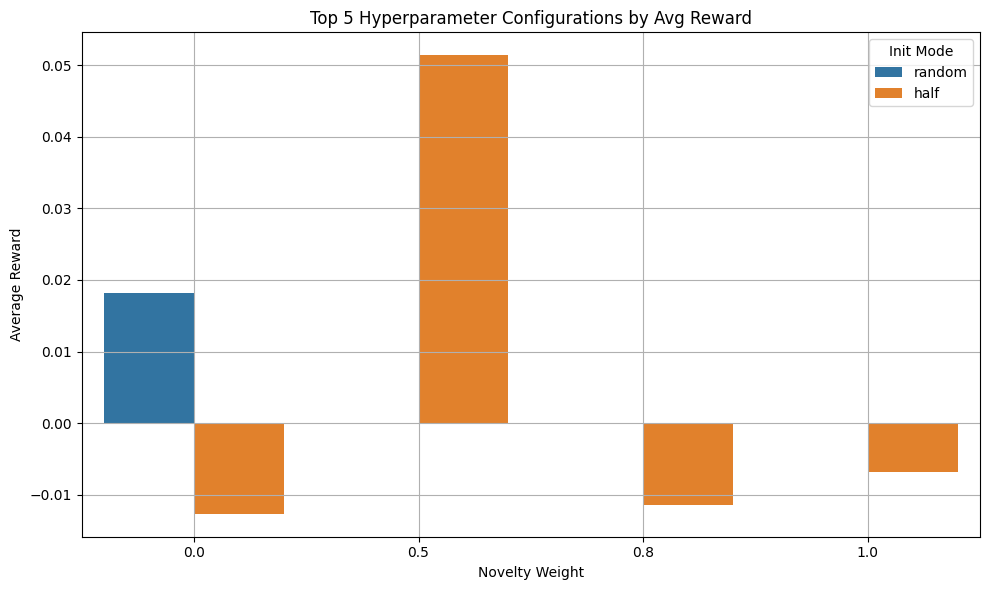

In [115]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top5, x="Novelty Weight", y="Avg Reward", hue="Init Mode")
plt.title("Top 5 Hyperparameter Configurations by Avg Reward")
plt.xlabel("Novelty Weight")
plt.ylabel("Average Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

###Viral Social Media

In [116]:
class ViralSocialMediaEnv:
    def __init__(self, state_size=10, action_size=4, max_steps=30, viral_steps=None, boost_value=0.2):
        self.state_size = state_size
        self.action_size = action_size
        self.max_steps = max_steps
        self.viral_steps = viral_steps or []
        self.boost_value = boost_value
        self.reset()

    def reset(self):
        self.timestep = 0
        self.engagement = np.random.rand()
        self.state = np.random.rand(self.state_size)
        return self.state

    def step(self, action, noise_level=0.02):
        self.timestep += 1
        noise = np.random.normal(0, noise_level)
        viral_boost = self.boost_value if self.timestep in self.viral_steps else 0.0
        engagement_change = np.sin(action + self.timestep) * 0.1 + noise + viral_boost
        self.engagement = np.clip(self.engagement + engagement_change, 0, 1)
        self.state = np.roll(self.state, -1)
        self.state[-1] = self.engagement
        reward = engagement_change
        done = self.timestep >= self.max_steps
        return self.state, reward, done, {}

In [117]:
class SimpleQLearningAgent:
    def __init__(self):
        self.q_table = np.zeros((1000, 4))
        self.lr = 0.1
        self.gamma = 0.95
        self.epsilon = 0.1
        self.action_size = 4

    def discretize_state(self, state):
        return int(np.sum(state * 10)) % 1000

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        idx = self.discretize_state(state)
        return np.argmax(self.q_table[idx])

    def learn(self, state, action, reward, next_state):
        idx = self.discretize_state(state)
        next_idx = self.discretize_state(next_state)
        target = reward + self.gamma * np.max(self.q_table[next_idx])
        self.q_table[idx, action] += self.lr * (target - self.q_table[idx, action])

In [118]:
def run_viral_boost():
    np.random.seed(42)
    viral_steps = [10, 11, 12]
    agent = SimpleQLearningAgent()
    env = ViralSocialMediaEnv(viral_steps=viral_steps)
    state = env.reset()
    rewards_viral = []

    for t in range(env.max_steps):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state
        rewards_viral.append(reward)
        if done:
            break

    agent_no_viral = SimpleQLearningAgent()
    env_no_viral = ViralSocialMediaEnv(viral_steps=[])
    state = env_no_viral.reset()
    rewards_normal = []

    for t in range(env_no_viral.max_steps):
        action = agent_no_viral.act(state)
        next_state, reward, done, _ = env_no_viral.step(action)
        agent_no_viral.learn(state, action, reward, next_state)
        state = next_state
        rewards_normal.append(reward)
        if done:
            break

    df = pd.DataFrame({
        "Step": np.arange(len(rewards_viral)),
        "Reward (Viral Boost)": rewards_viral,
        "Reward (Normal)": rewards_normal
    })

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="Step", y="Reward (Viral Boost)", label="With Viral Boost")
    sns.lineplot(data=df, x="Step", y="Reward (Normal)", label="Without Boost")
    plt.axvspan(10, 12, color='red', alpha=0.1, label="Viral Window")
    plt.title("Agent Reward Response to Viral Boost")
    plt.xlabel("Timestep")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [119]:
def simulate_post_types():
    def simulate_post(label, viral_steps):
        env = ViralSocialMediaEnv(viral_steps=viral_steps)
        agent = SimpleQLearningAgent()
        state = env.reset()
        rewards = []
        for _ in range(env.max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            rewards.append(reward)
            if done:
                break
        return pd.DataFrame({
            "Step": np.arange(len(rewards)),
            "Reward": rewards,
            "Post Type": label
        })

    post_a = simulate_post("Post A", viral_steps=[5, 6, 7])
    post_b = simulate_post("Post B", viral_steps=[20, 21, 22])

    df_ab = pd.concat([post_a, post_b], ignore_index=True)

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_ab, x="Step", y="Reward", hue="Post Type")
    plt.title("A/B Post Type Reward Trajectories")
    plt.xlabel("Timestep")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

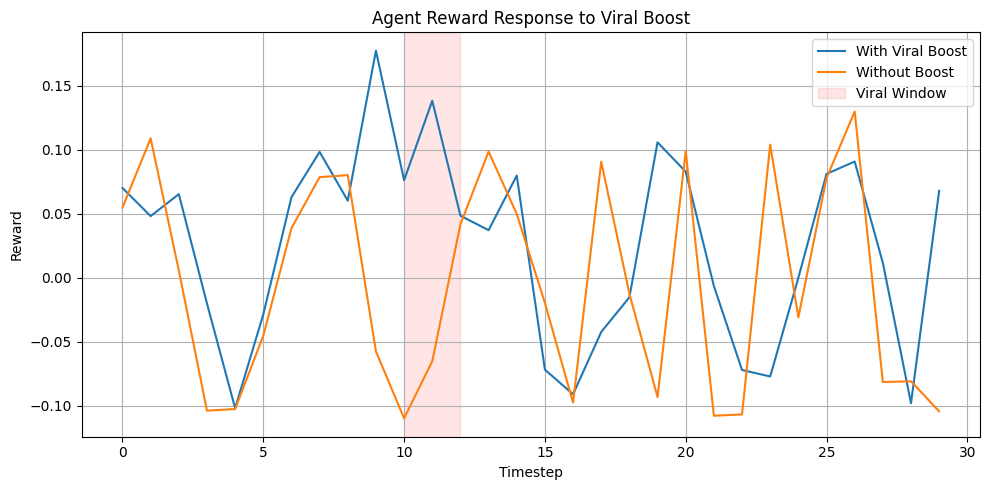

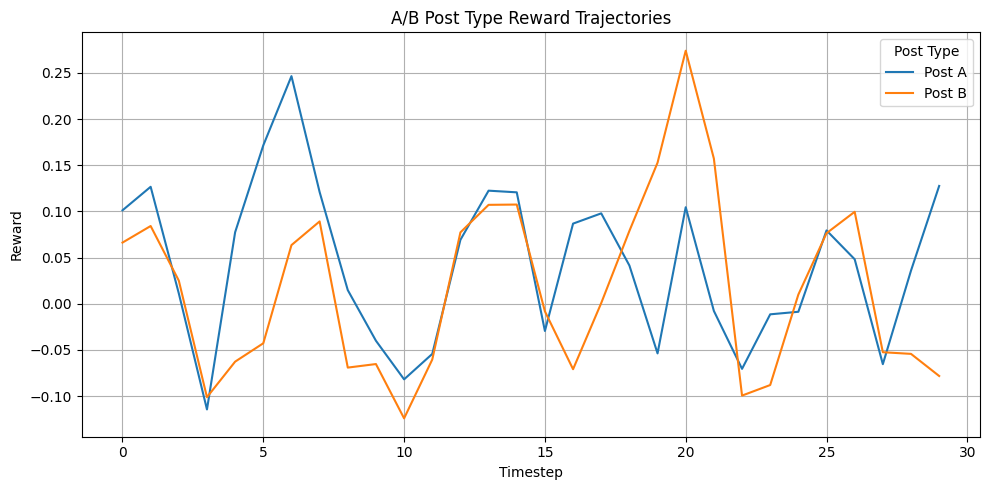

In [120]:
run_viral_boost()
simulate_post_types()

In [121]:
def simulate_post(label, viral_steps):
    env = ViralSocialMediaEnv(viral_steps=viral_steps)
    agent = SimpleQLearningAgent()
    state = env.reset()
    total_reward = 0
    for _ in range(env.max_steps):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        if done:
            break
    return {'Post': label, 'Total Reward': total_reward}

post_configs = [
    ("Post A", [5, 6, 7]),
    ("Post B", [10, 11, 12]),
    ("Post C", [15, 16, 17]),
    ("Post D", [20, 21, 22])
]

post_results = [simulate_post(label, steps) for label, steps in post_configs]
post_df = pd.DataFrame(post_results).sort_values(by="Total Reward", ascending=False)
print("Top Performing Posts:")
print(post_df)

Top Performing Posts:
     Post  Total Reward
2  Post C      0.975858
0  Post A      0.681796
1  Post B      0.580807
3  Post D      0.245413


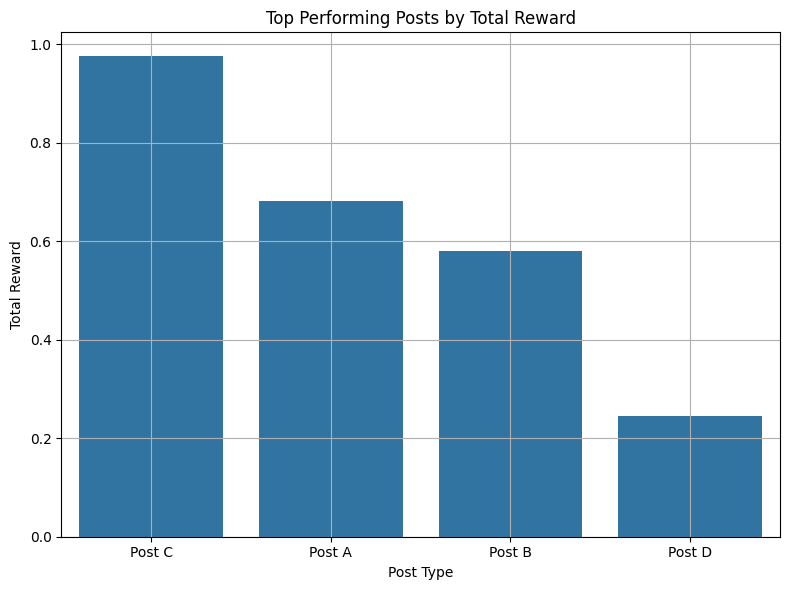

In [122]:
plt.figure(figsize=(8, 6))
sns.barplot(data=post_df, x="Post", y="Total Reward")
plt.title("Top Performing Posts by Total Reward")
plt.xlabel("Post Type")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()